In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Reproducibility
def set_random_seeds(seed: int = 42) -> None:
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def get_device() -> torch.device:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    return device


In [11]:
class SentimentDataset(Dataset):
    """Custom dataset for sentiment analysis."""

    def __init__(self, texts: List[str], labels: List[int], tokenizer, max_length: int = 128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self) -> int:
        return len(self.texts)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [12]:
class SentimentAnalyzer(nn.Module):
    """Transformer-based sentiment analysis model."""

    def __init__(self, model_name: str = 'distilbert-base-uncased', num_classes: int = 3, dropout_rate: float = 0.3):
        super(SentimentAnalyzer, self).__init__()
        self.transformer = AutoModel.from_pretrained(model_name)

        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Sequential(
            nn.Linear(self.transformer.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state.mean(dim=1)  # CLS token
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits


In [13]:
def load_and_prepare_data():
    df_main = pd.read_csv("cleaned_dataset.csv")
    df_ref = pd.read_csv('labels_reference_cleaned.csv')

    sentiment_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}

    # ---- MAIN DATASET ----
    df_main = df_main[['Text_Cleaned', 'Sentiment']].dropna()
    df_main['sentiment_label'] = df_main['Sentiment'].map(sentiment_map)
    df_main = df_main[['Text_Cleaned', 'sentiment_label']]
    df_main = df_main.rename(columns={'Text_Cleaned': 'text'})

    # ---- REF DATASET ----
    df_ref = df_ref[['clean_text', 'sentiment_label']].dropna()
    df_ref = df_ref.rename(columns={'clean_text': 'text'})

    # ---- COMBINE ----
    df = pd.concat([df_main, df_ref], ignore_index=True)

    # ---- CLEANING PIPELINE ----

    # ensure string
    df['text'] = df['text'].astype(str)

    # remove duplicates
    df = df.drop_duplicates(subset='text')

    # remove very short sentences
    df = df[df['text'].str.split().str.len() > 5]

    # remove junk twitter words
    df = df[~df['text'].str.contains("haha|hahah|lol|powerblog|omg", case=False)]

    # remove extremely short characters
    df = df[df['text'].str.len() > 25]

    # remove invalid labels
    df = df[df['sentiment_label'].isin([0,1,2])]

    df = df.reset_index(drop=True)

    print("Final cleaned dataset:", df.shape)
    print(df['sentiment_label'].value_counts())

    return df




In [14]:
def create_data_loaders(df, tokenizer, test_size=0.2, val_size=0.1, batch_size=16, max_length=192):

    X = df['text'].tolist()
    y = df['sentiment_label'].tolist()

    # Train + Test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )

    # Train + Validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_size, stratify=y_train, random_state=42
    )

    train_dataset = SentimentDataset(X_train, y_train, tokenizer, max_length)
    val_dataset = SentimentDataset(X_val, y_val, tokenizer, max_length)
    test_dataset = SentimentDataset(X_test, y_test, tokenizer, max_length)

    return (
        DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
        DataLoader(val_dataset, batch_size=batch_size, shuffle=False),
        DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    )

In [15]:

def train_model(model, train_loader, val_loader, num_epochs=20, lr=5e-6):

    device = get_device()
    model = model.to(device)

    # Freeze transformer for warmup
    for param in model.transformer.parameters():
        param.requires_grad = False

    optimizer = optim.AdamW(model.parameters(), lr=lr)
    class_counts = torch.tensor(df['sentiment_label'].value_counts().sort_index().values)
    weights = 1.0 / class_counts
    weights = weights / weights.sum()
    criterion = nn.CrossEntropyLoss(weight=weights.to(device))


    losses = []
    best_val = 0
    patience = 3
    counter = 0

    for epoch in range(num_epochs):
        # Unfreeze after 2 epochs
        if epoch == 2:
            for param in model.transformer.parameters():
                param.requires_grad = True

        # ---- TRAIN ----
        model.train()
        total_loss, correct, total = 0, 0, 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        losses.append(total_loss / len(train_loader))

        # ---- VALIDATION ----
        model.eval()
        val_correct, val_total = 0, 0

        with torch.no_grad():
            for batch in val_loader:
                ids = batch['input_ids'].to(device)
                mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(ids, mask)
                preds = torch.argmax(outputs, dim=1)

                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total

        print(f"Epoch {epoch+1} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        # ---- EARLY STOPPING ----
        if val_acc > best_val:
            best_val = val_acc
            counter = 0
            torch.save(model.state_dict(), "best_model.pt")
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered")
                break

    return losses


In [16]:
def plot_confusion_matrix(true_labels, preds):
    cm = confusion_matrix(true_labels, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative','Neutral','Positive'],
                yticklabels=['Negative','Neutral','Positive'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def plot_training_loss(losses):
    plt.plot(losses, 'b-')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()


In [17]:
def predict_sentiment(model, tokenizer, text, device):
    model = model.to(device)
    model.eval()

    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=192,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        probs = torch.softmax(outputs, dim=1)
        pred = torch.argmax(probs, dim=1).item()

    sentiment_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    return sentiment_map[pred], probs[0].cpu().numpy()


Final cleaned dataset: (378, 2)
sentiment_label
2    209
1    104
0     65
Name: count, dtype: int64


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Using device: cuda
Epoch 1 | Train Acc: 0.3137 | Val Acc: 0.2903
Epoch 2 | Train Acc: 0.2804 | Val Acc: 0.2903
Epoch 3 | Train Acc: 0.2731 | Val Acc: 0.2903
Epoch 4 | Train Acc: 0.3801 | Val Acc: 0.3871
Epoch 5 | Train Acc: 0.4760 | Val Acc: 0.5806
Epoch 6 | Train Acc: 0.5830 | Val Acc: 0.6452
Epoch 7 | Train Acc: 0.6642 | Val Acc: 0.6452
Epoch 8 | Train Acc: 0.6568 | Val Acc: 0.6452
Epoch 9 | Train Acc: 0.7159 | Val Acc: 0.6774
Epoch 10 | Train Acc: 0.7417 | Val Acc: 0.6774
Epoch 11 | Train Acc: 0.8007 | Val Acc: 0.6774
Epoch 12 | Train Acc: 0.8118 | Val Acc: 0.7419
Epoch 13 | Train Acc: 0.8930 | Val Acc: 0.7419
Epoch 14 | Train Acc: 0.9373 | Val Acc: 0.7742
Epoch 15 | Train Acc: 0.9520 | Val Acc: 0.7742
Epoch 16 | Train Acc: 0.9483 | Val Acc: 0.8065
Epoch 17 | Train Acc: 0.9705 | Val Acc: 0.7419
Epoch 18 | Train Acc: 0.9815 | Val Acc: 0.7742
Epoch 19 | Train Acc: 0.9926 | Val Acc: 0.8065
Early stopping triggered
Loaded best model
Using device: cuda


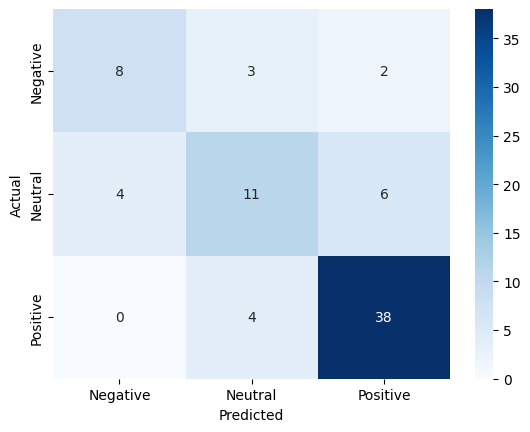

In [18]:
set_random_seeds(42)

def evaluate_model(model, test_loader):
    device = get_device()
    model.to(device)
    model.eval()
    true_labels = []
    preds = []
    with torch.no_grad():
        for batch in test_loader:
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(ids, mask)
            batch_preds = torch.argmax(outputs, dim=1)
            true_labels.extend(labels.cpu().numpy())
            preds.extend(batch_preds.cpu().numpy())
    return true_labels, preds

df = load_and_prepare_data()

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = SentimentAnalyzer(model_name=model_name, num_classes=3)

train_loader, val_loader, test_loader = create_data_loaders(df, tokenizer)

losses = train_model(model, train_loader, val_loader, num_epochs=20)

model.load_state_dict(torch.load("best_model.pt"))
print("Loaded best model")

true_labels, preds = evaluate_model(model, test_loader)

plot_confusion_matrix(true_labels, preds)

In [19]:
device = get_device()
samples = [
    "I love this amazing product! It's fantastic!",
    "This is terrible. I hate it so much.",
    "It's okay, nothing special but not bad either."
]

for s in samples:
    sentiment, probs = predict_sentiment(model, tokenizer, s, device)
    print(f"Text: {s}")
    print(f"Predicted: {sentiment} | Probabilities: {probs}")
    print("-"*40)


Using device: cuda
Text: I love this amazing product! It's fantastic!
Predicted: Positive | Probabilities: [0.03639994 0.04593579 0.9176643 ]
----------------------------------------
Text: This is terrible. I hate it so much.
Predicted: Negative | Probabilities: [0.64788616 0.15773858 0.1943752 ]
----------------------------------------
Text: It's okay, nothing special but not bad either.
Predicted: Negative | Probabilities: [0.4942603  0.29176116 0.21397847]
----------------------------------------


In [20]:
from sklearn.metrics import accuracy_score, classification_report

true_labels, preds = evaluate_model(model, test_loader)

print("\nFINAL TEST ACCURACY:", accuracy_score(true_labels, preds))
print("\nCLASSIFICATION REPORT:\n")
print(classification_report(true_labels, preds, target_names=['Negative','Neutral','Positive']))


Using device: cuda

FINAL TEST ACCURACY: 0.75

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

    Negative       0.67      0.62      0.64        13
     Neutral       0.61      0.52      0.56        21
    Positive       0.83      0.90      0.86        42

    accuracy                           0.75        76
   macro avg       0.70      0.68      0.69        76
weighted avg       0.74      0.75      0.74        76



In [21]:
text = "I absolutely hate this product"
sentiment, probs = predict_sentiment(model, tokenizer, text, device)
print(sentiment, probs)


Negative [0.48086306 0.24509573 0.2740412 ]
